In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

### Intro Overview of PyMC examples

In [4]:
data = np.repeat((0, 1), (3, 6))

In [14]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

In [15]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.1.2


In [16]:
with pm.Model() as basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [17]:
basic_model

alpha ~ N(0, 10)
 beta ~ N(0, 10)
sigma ~ N**+(0, 1)
Y_obs ~ N(f(alpha, beta), sigma)

In [18]:
with basic_model:
    sdata = pm.sample() 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [19]:
sdata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [20]:
sdata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.20946159, 1.24767792, 1.24167437, 1.15962743, 1.11087661],
       [1.10725026, 1.17096548, 1.12162506, 1.09517892, 1.24964133],
       [1.29017997, 1.35005407, 1.12535469, 1.05871323, 0.89105572],
       [1.1996609 , 1.21988172, 1.28023933, 1.14131246, 1.10545433]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

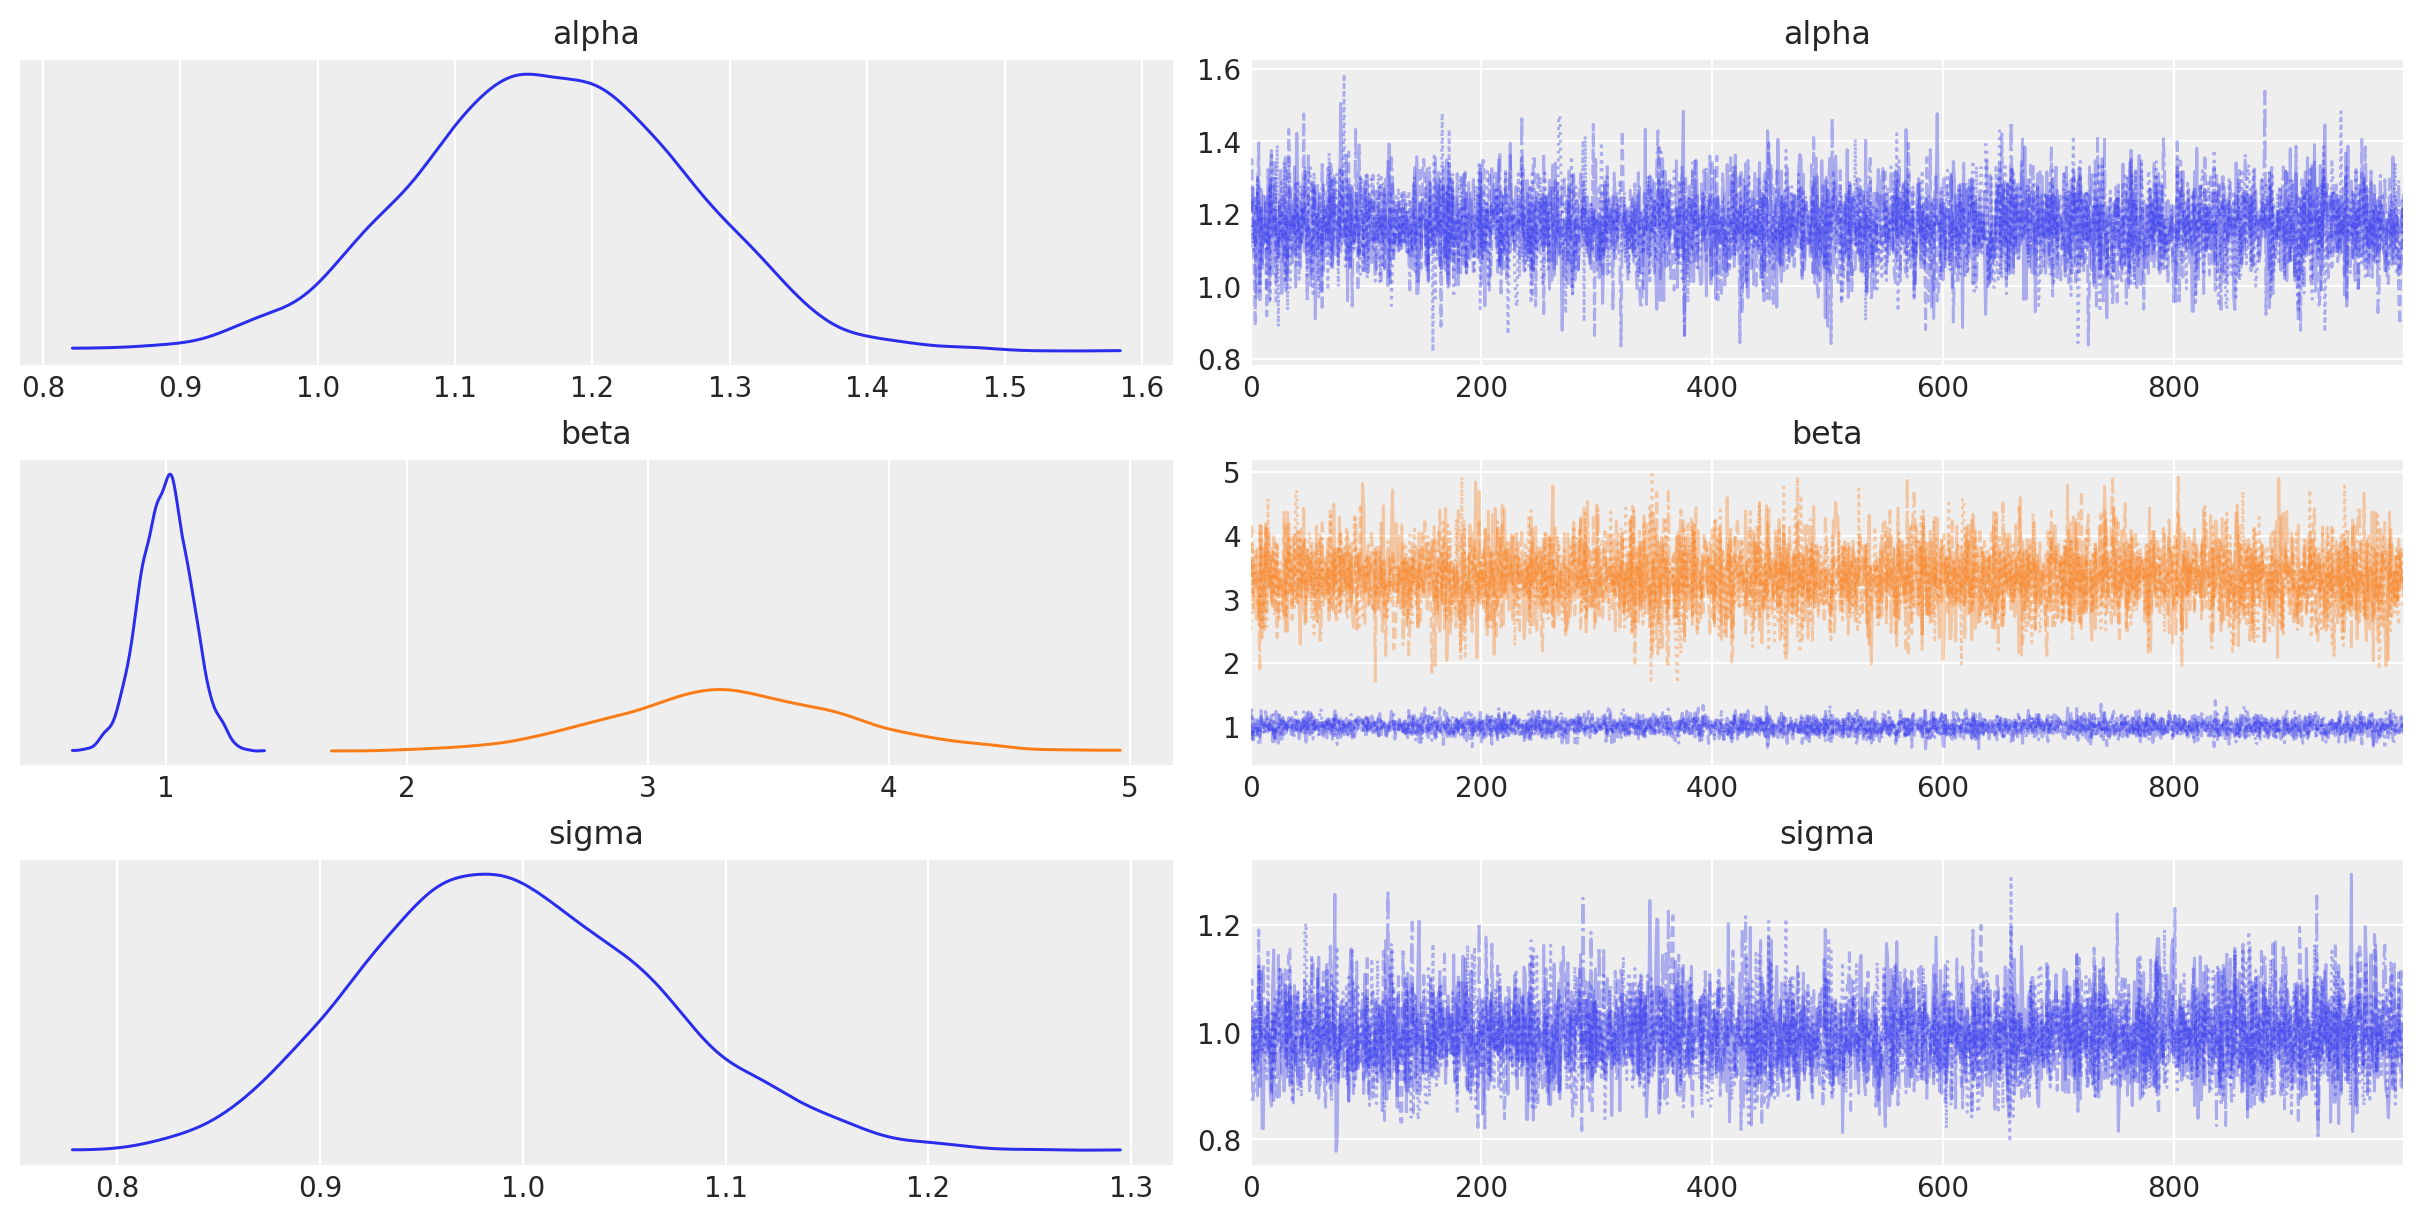

In [21]:
az.plot_trace(sdata, combined=True);

In [22]:
az.summary(sdata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.17,0.10,0.99,1.36,0.00,0.0,5321.28,3301.18,1.0
beta[0],1.00,0.11,0.80,1.20,0.00,0.0,4873.64,3445.73,1.0
beta[1],3.35,0.49,2.43,4.29,0.01,0.0,5750.34,3134.59,1.0
sigma,1.00,0.07,0.86,1.13,0.00,0.0,5526.65,2745.86,1.0


In [24]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


In [25]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

In [27]:
X.head()

,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,-1.004938,1.078165,2.227502,2.480475,1.782293,-0.978004,1.179344,0.616250,-0.772789,1.132532
12,0.985234,-0.080289,-0.911722,-0.399157,-0.555520,-1.562492,1.179344,0.616250,1.281203,-0.874235
14,-1.004938,1.078165,-0.911722,-0.399157,-0.555520,1.359947,1.179344,0.616250,1.281203,1.132532
19,0.985234,-1.238742,1.181094,-0.399157,-0.555520,-0.978004,1.179344,0.616250,-0.772789,1.132532
21,0.985234,-0.080289,1.181094,-0.399157,1.782293,1.359947,-0.839533,-1.606652,1.281203,1.132532


In [33]:
D0 = int(D / 2)

In [34]:
import pytensor.tensor as at

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)
    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 2, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 0.1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed=y.values)

In [36]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


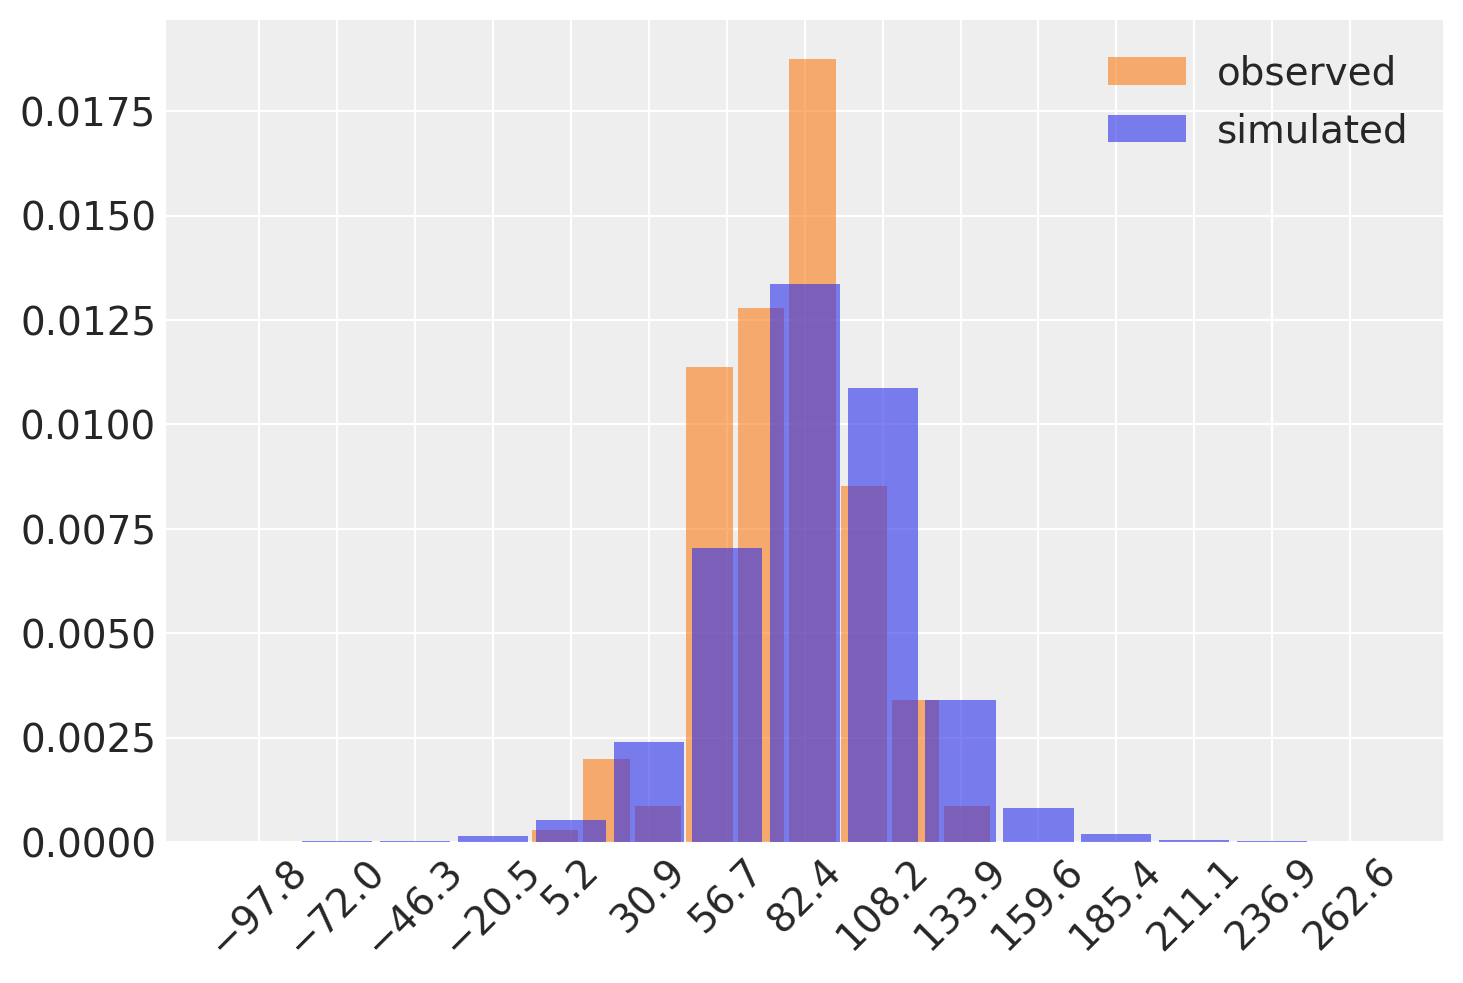

In [37]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

In [38]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


In [39]:
# higher target_accept thresh makes sure the sampling chains are more conservative,
# at the expense of longer simulation time

with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 46 seconds.


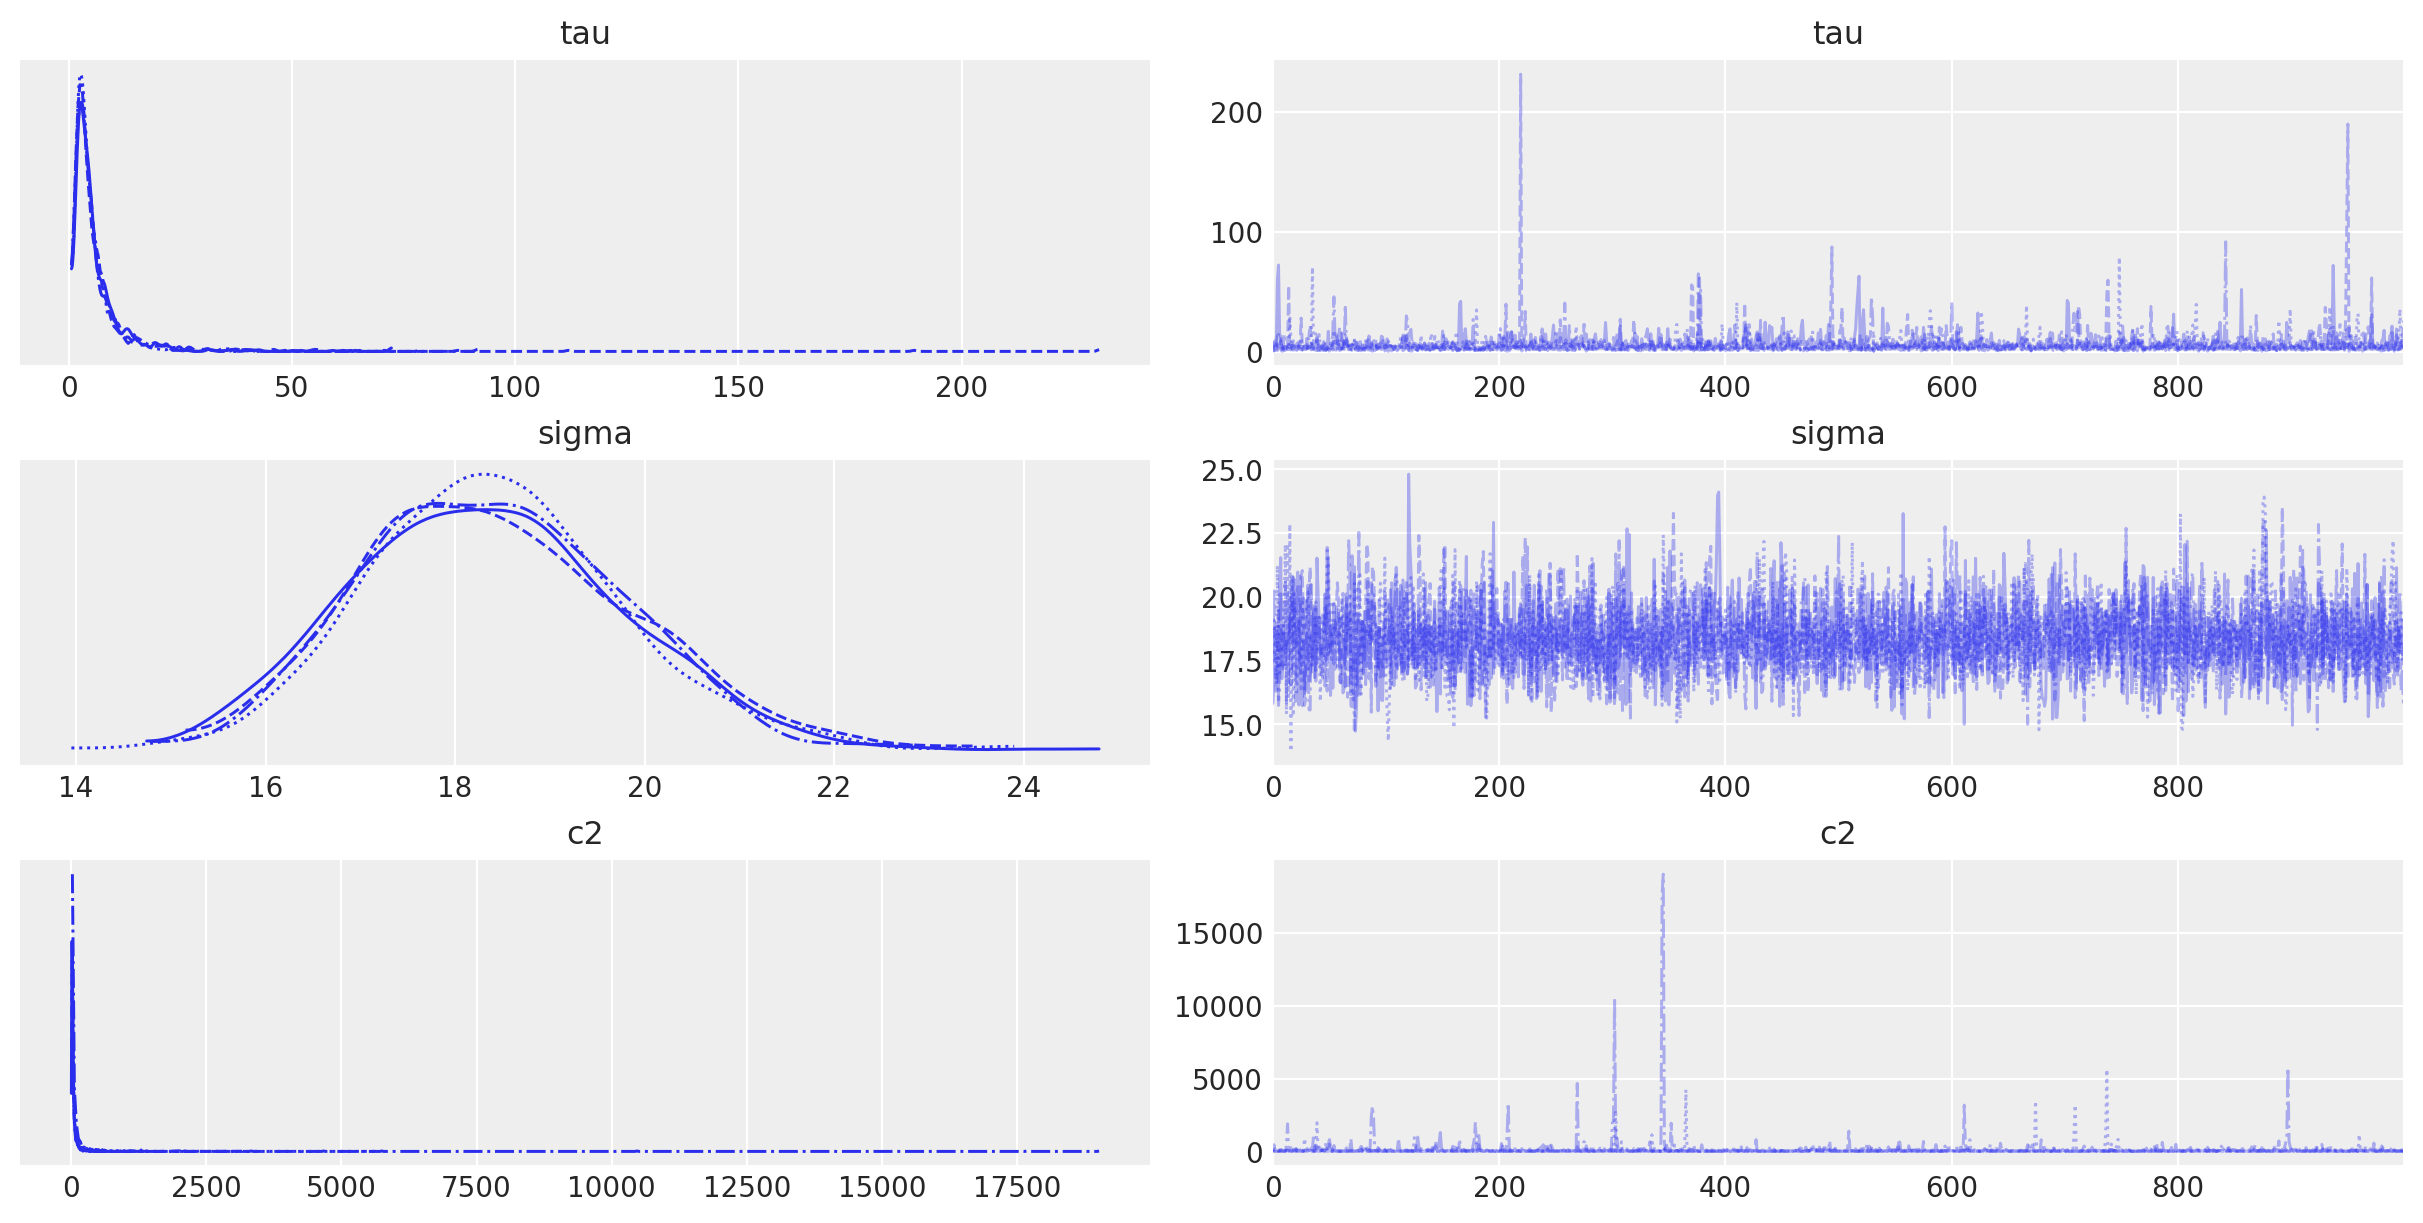

In [40]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]);

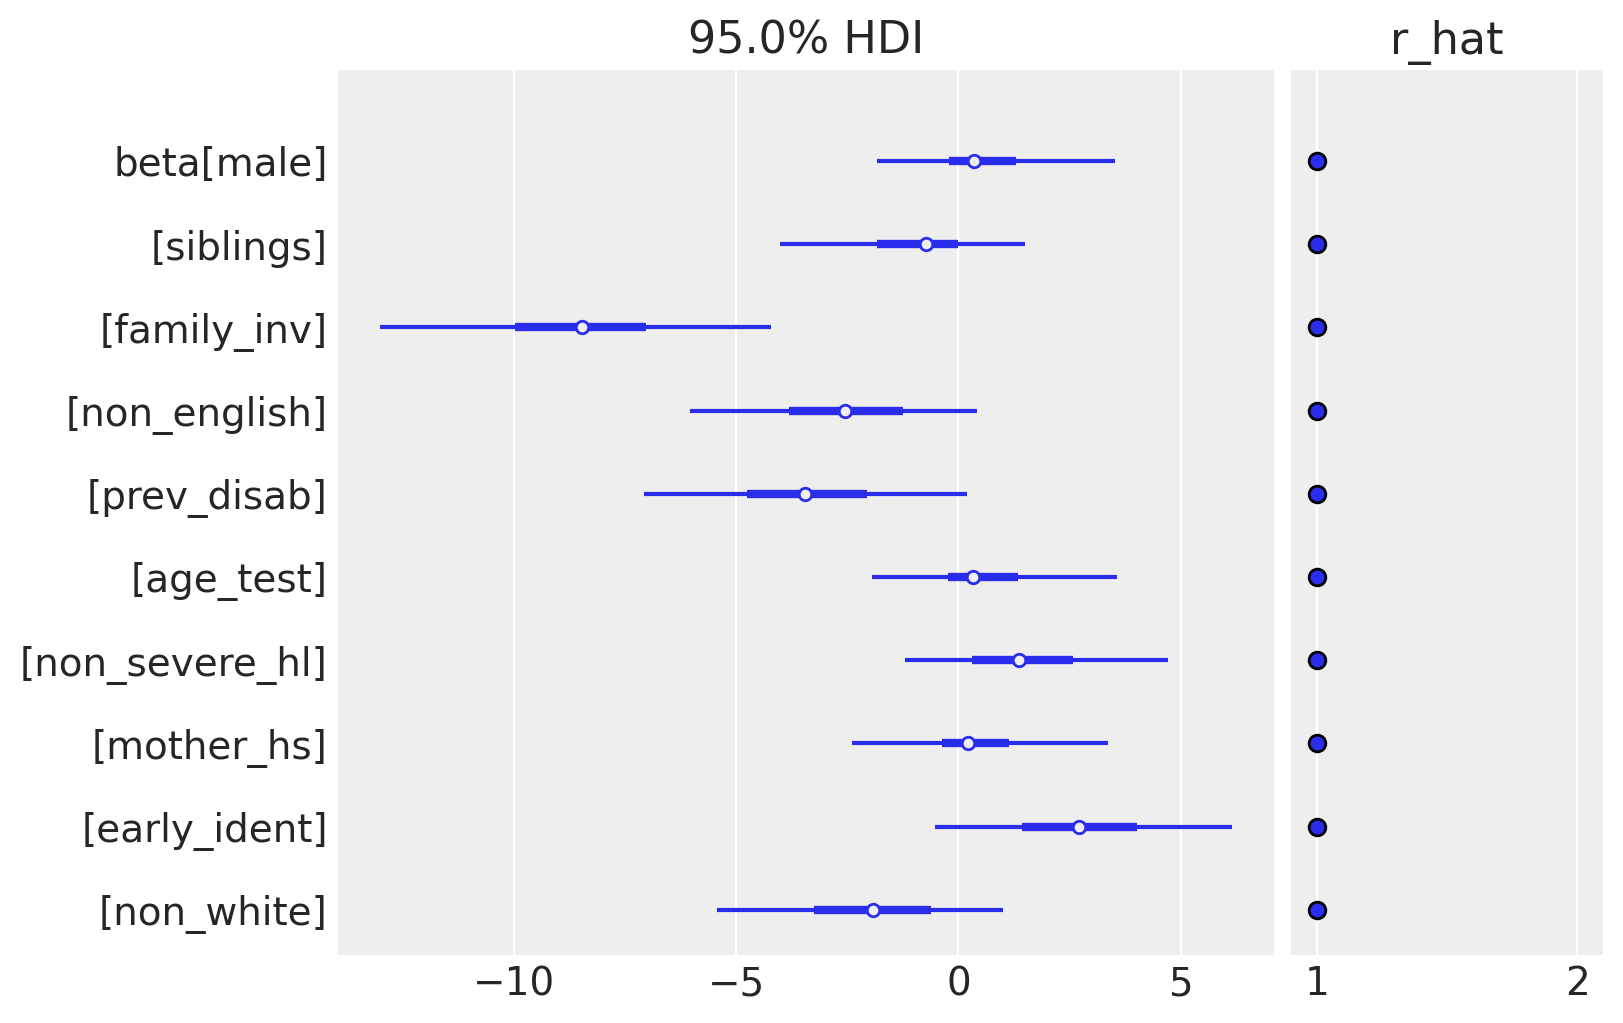

In [41]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

### Case 2: Coal Mining Safety

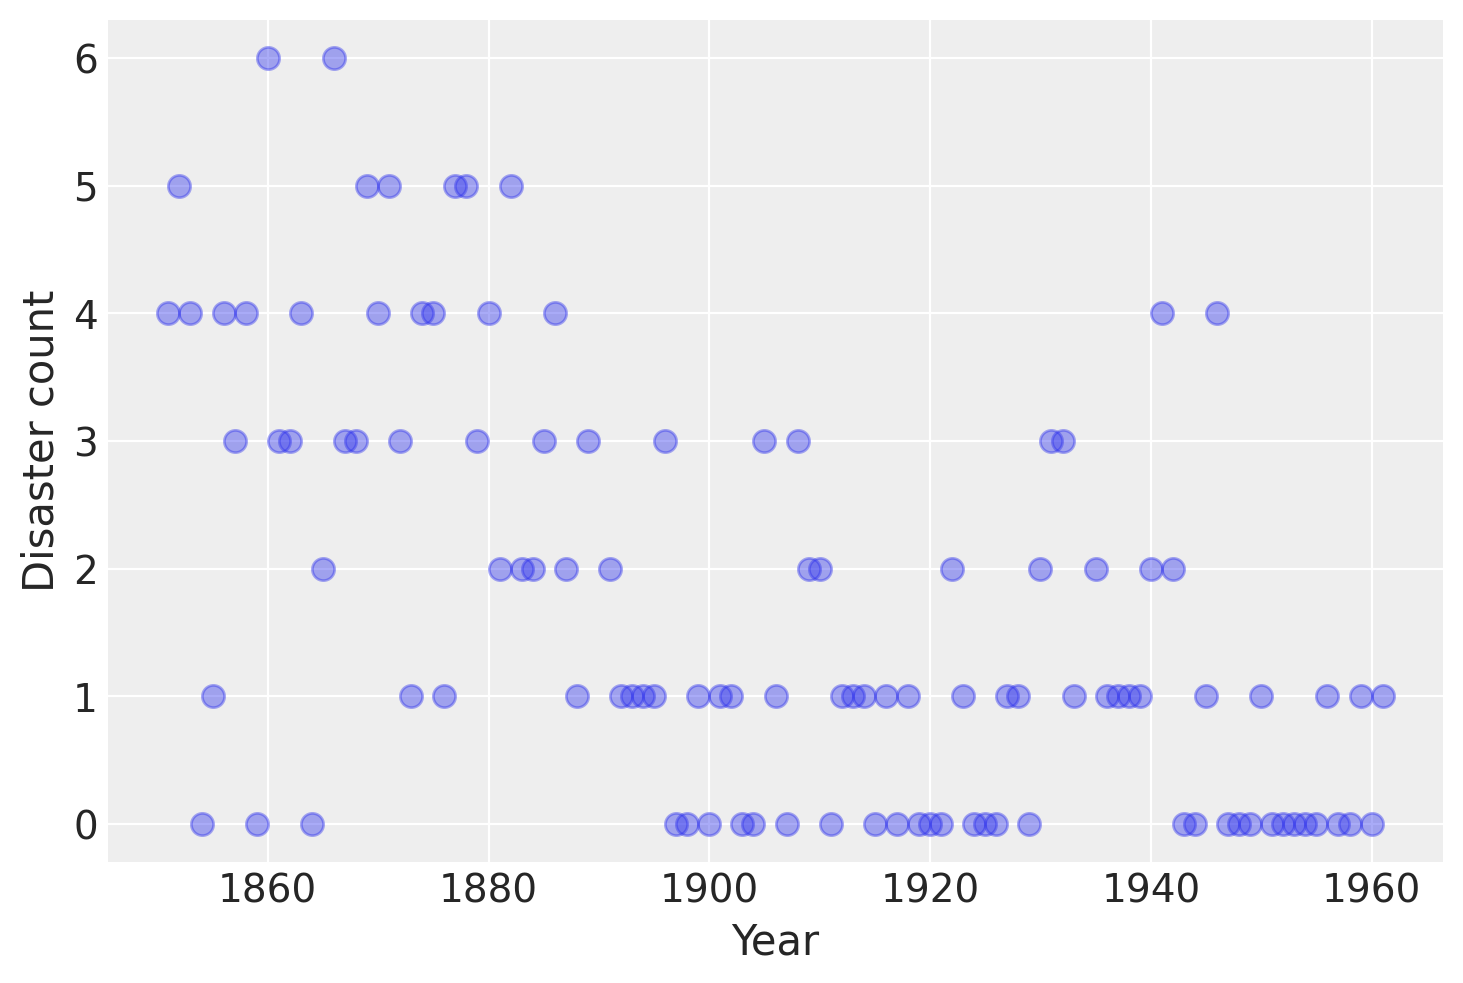

In [42]:
disaster_data = pd.Series(
    [4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
    3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
    2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
    1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
    0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
    3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
    0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
)

# fmt: on
years = np.arange(1851, 1962)

plt.plot(years, disaster_data, "o", markersize=8, alpha=0.4)
plt.ylabel("Disaster count")
plt.xlabel("Year");

In [43]:
with pm.Model() as disaster_model:
    switchpoint = pm.DiscreteUniform("switchpoint", lower=years.min(), upper=years.max())

    # Priors for pre- and post-sw|itch rates number of disasters
    early_rate = pm.Exponential("early_rate", 1.0)
    late_rate = pm.Exponential("late_rate", 1.0)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)

    disasters = pm.Poisson("disasters", rate, observed=disaster_data)

/home/jaredxfeng/.local/share/virtualenvs/rethinking-JoO_cdOo/lib/python3.10/site-packages/pymc/model.py:1379: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/home/jaredxfeng/.local/share/virtualenvs/rethinking-JoO_cdOo/lib/python3.10/site-packages/pymc/model.py:1402: ImputationWarning: Data in disasters contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [45]:
with disaster_model:
    idata = pm.sample(10000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [switchpoint]
>>Metropolis: [disasters_missing]
>NUTS: [early_rate, late_rate]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 16 seconds.


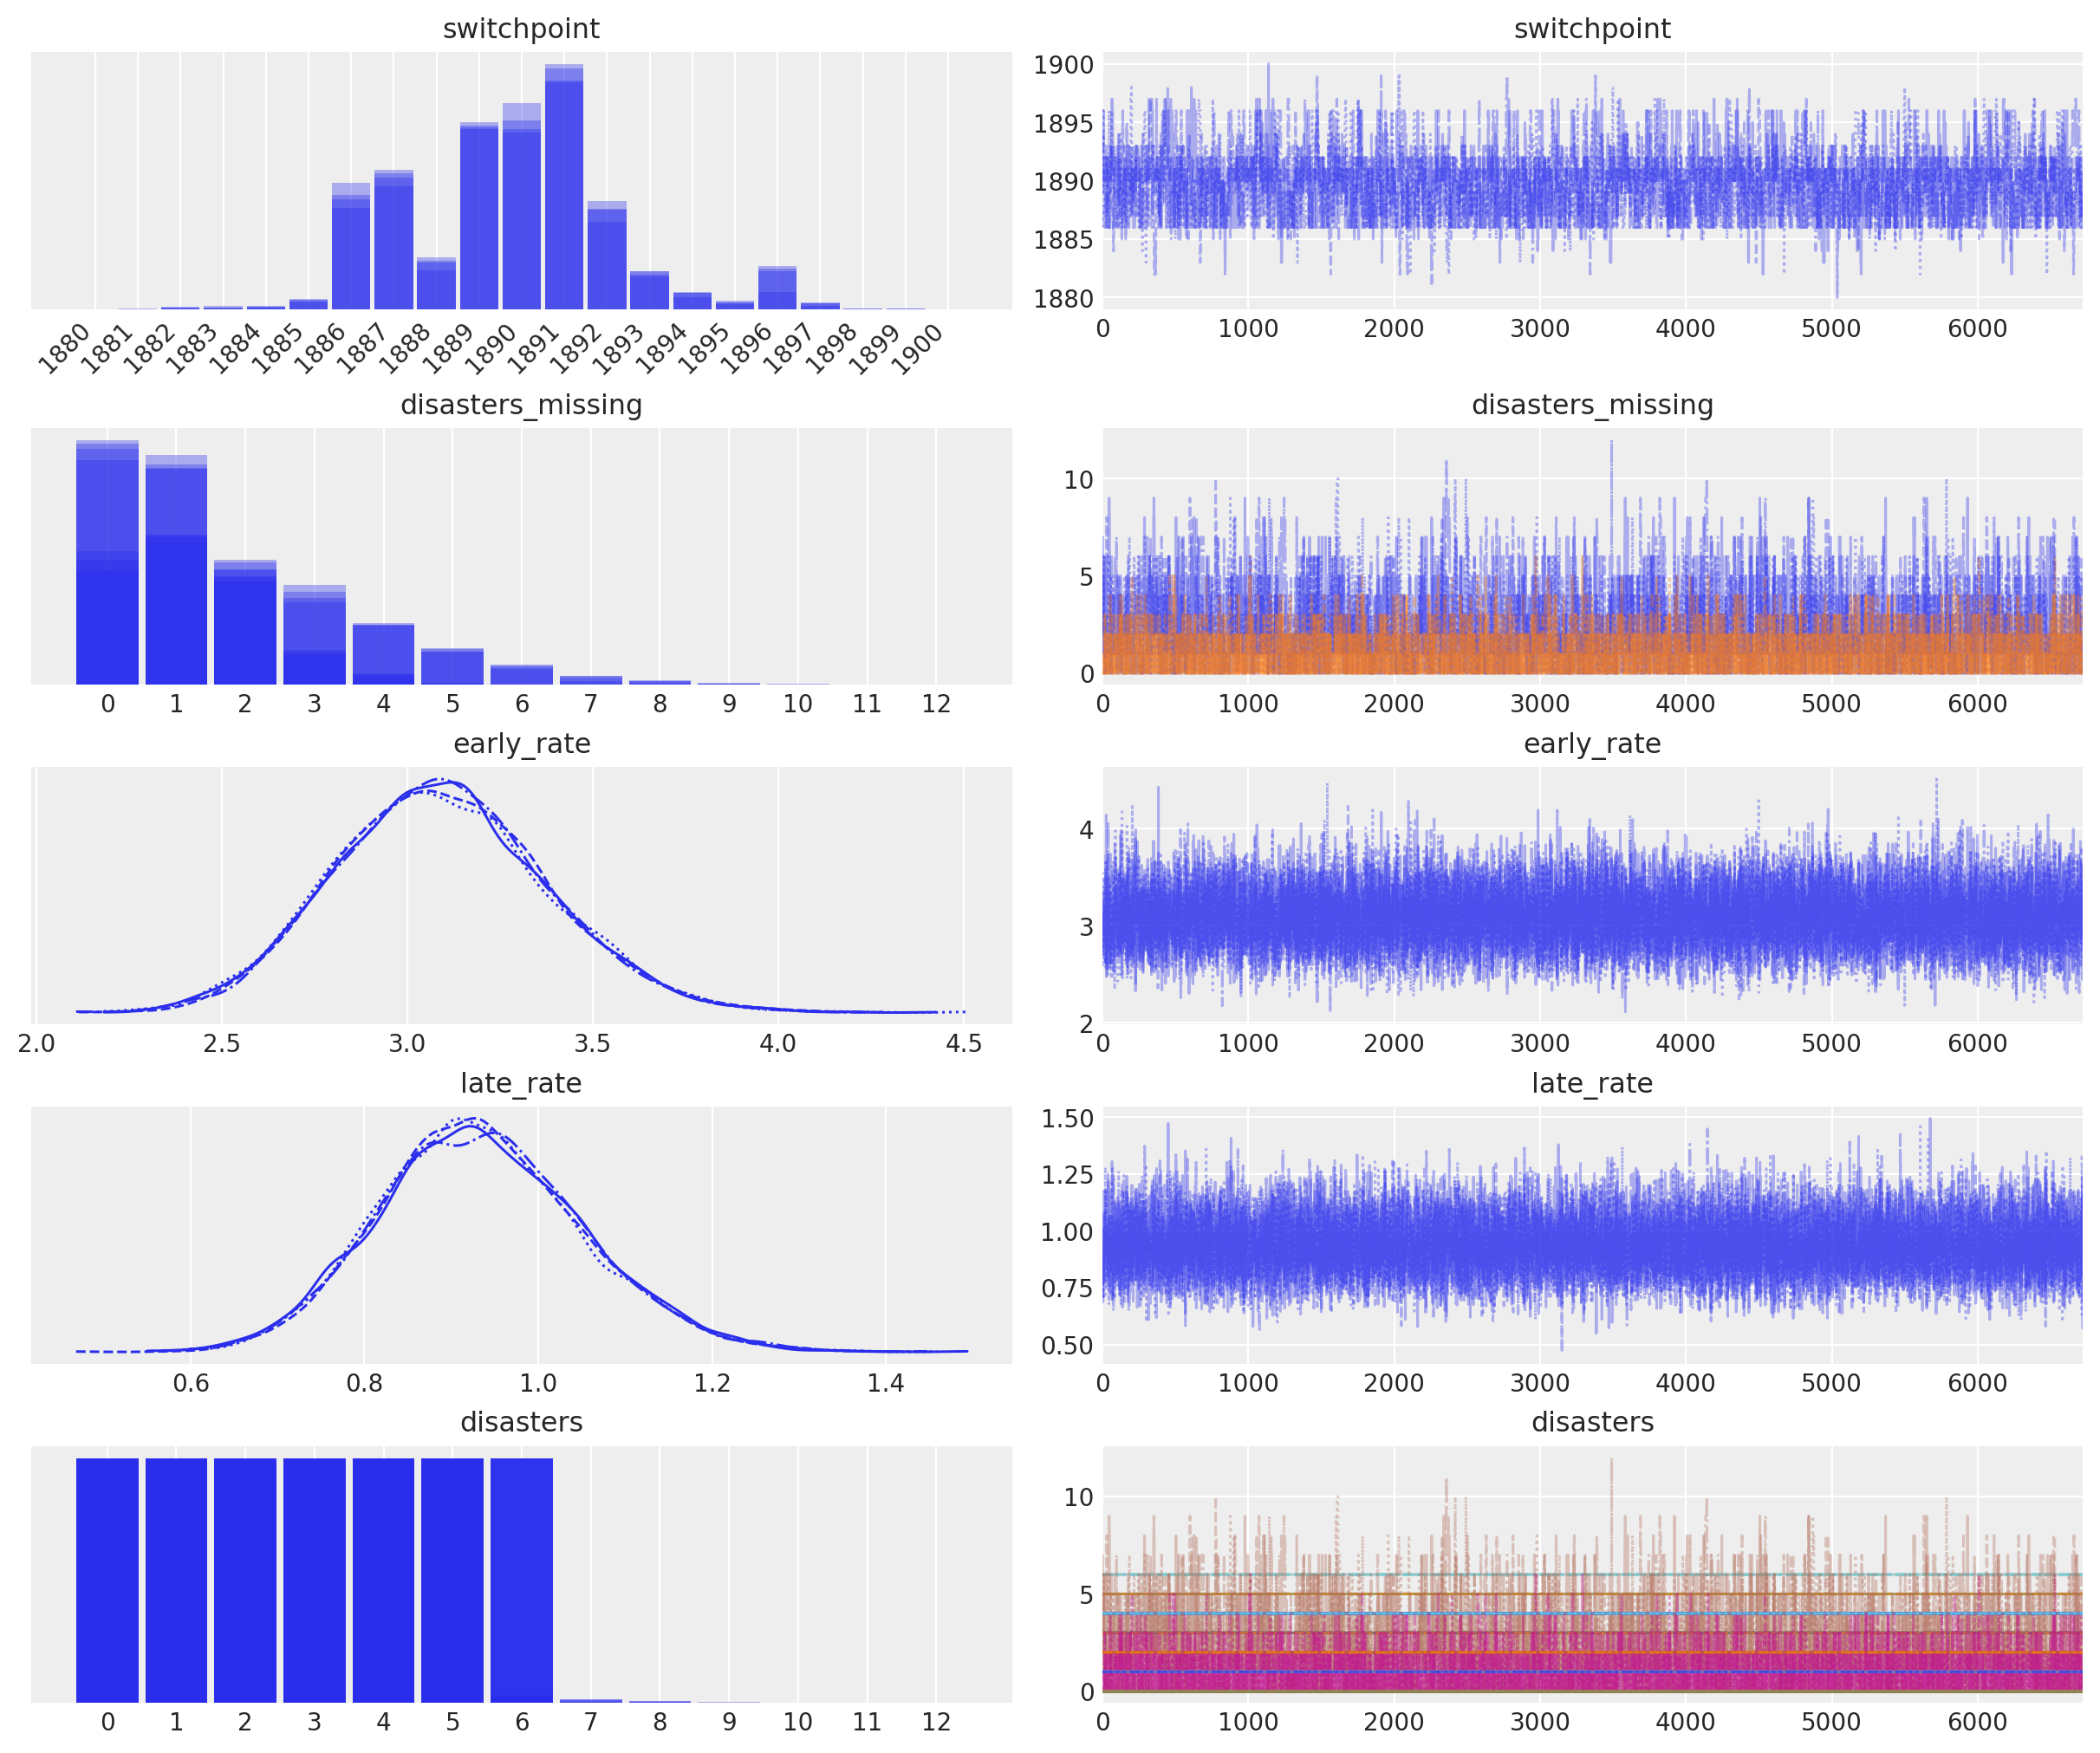

In [49]:
axes_arr = az.plot_trace(idata)
plt.draw()
for ax in axes_arr.flatten():
    if ax.get_title() == "switchpoint":
        labels = [label.get_text() for label in ax.get_xticklabels()]
        ax.set_xticklabels(labels, rotation=45, ha="right")
        break
plt.draw()

In [55]:
idata.posterior

<xarray.Dataset>
Dimensions:                  (chain: 4, draw: 6722, disasters_missing_dim_0: 2,
                              disasters_dim_0: 111)
Coordinates:
  * chain                    (chain) int64 0 1 2 3
  * draw                     (draw) int64 0 1 2 3 4 ... 6717 6718 6719 6720 6721
  * disasters_missing_dim_0  (disasters_missing_dim_0) int64 0 1
  * disasters_dim_0          (disasters_dim_0) int64 0 1 2 3 ... 107 108 109 110
Data variables:
    switchpoint              (chain, draw) int64 1892 1892 1892 ... 1886 1886
    disasters_missing        (chain, draw, disasters_missing_dim_0) int64 7 ....
    early_rate               (chain, draw) float64 3.06 3.091 ... 2.864 3.1
    late_rate                (chain, draw) float64 1.027 0.8581 ... 1.091 0.871
    disasters                (chain, draw, disasters_dim_0) int64 4 5 4 ... 0 1
Attributes:
    created_at:                 2023-03-25T23:10:16.976121
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.1.2
    sampling_time:              12.363125801086426
    tuning_steps:               1000

In [56]:
trace = idata.posterior.stack(draws=("chain", "draw"))

In [59]:
trace

<xarray.Dataset>
Dimensions:                  (draws: 26888, disasters_missing_dim_0: 2,
                              disasters_dim_0: 111)
Coordinates:
  * disasters_missing_dim_0  (disasters_missing_dim_0) int64 0 1
  * disasters_dim_0          (disasters_dim_0) int64 0 1 2 3 ... 107 108 109 110
  * draws                    (draws) object MultiIndex
  * chain                    (draws) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * draw                     (draws) int64 0 1 2 3 4 ... 6718 6719 6720 6721
Data variables:
    switchpoint              (draws) int64 1892 1892 1892 ... 1886 1886 1886
    disasters_missing        (disasters_missing_dim_0, draws) int64 7 6 ... 0 2
    early_rate               (draws) float64 3.06 3.091 2.782 ... 3.1 2.864 3.1
    late_rate                (draws) float64 1.027 0.8581 1.176 ... 1.091 0.871
    disasters                (disasters_dim_0, draws) int64 4 4 4 4 ... 1 1 1 1
Attributes:
    created_at:                 2023-03-25T23:10:16.976121
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.1.2
    sampling_time:              12.363125801086426
    tuning_steps:               1000

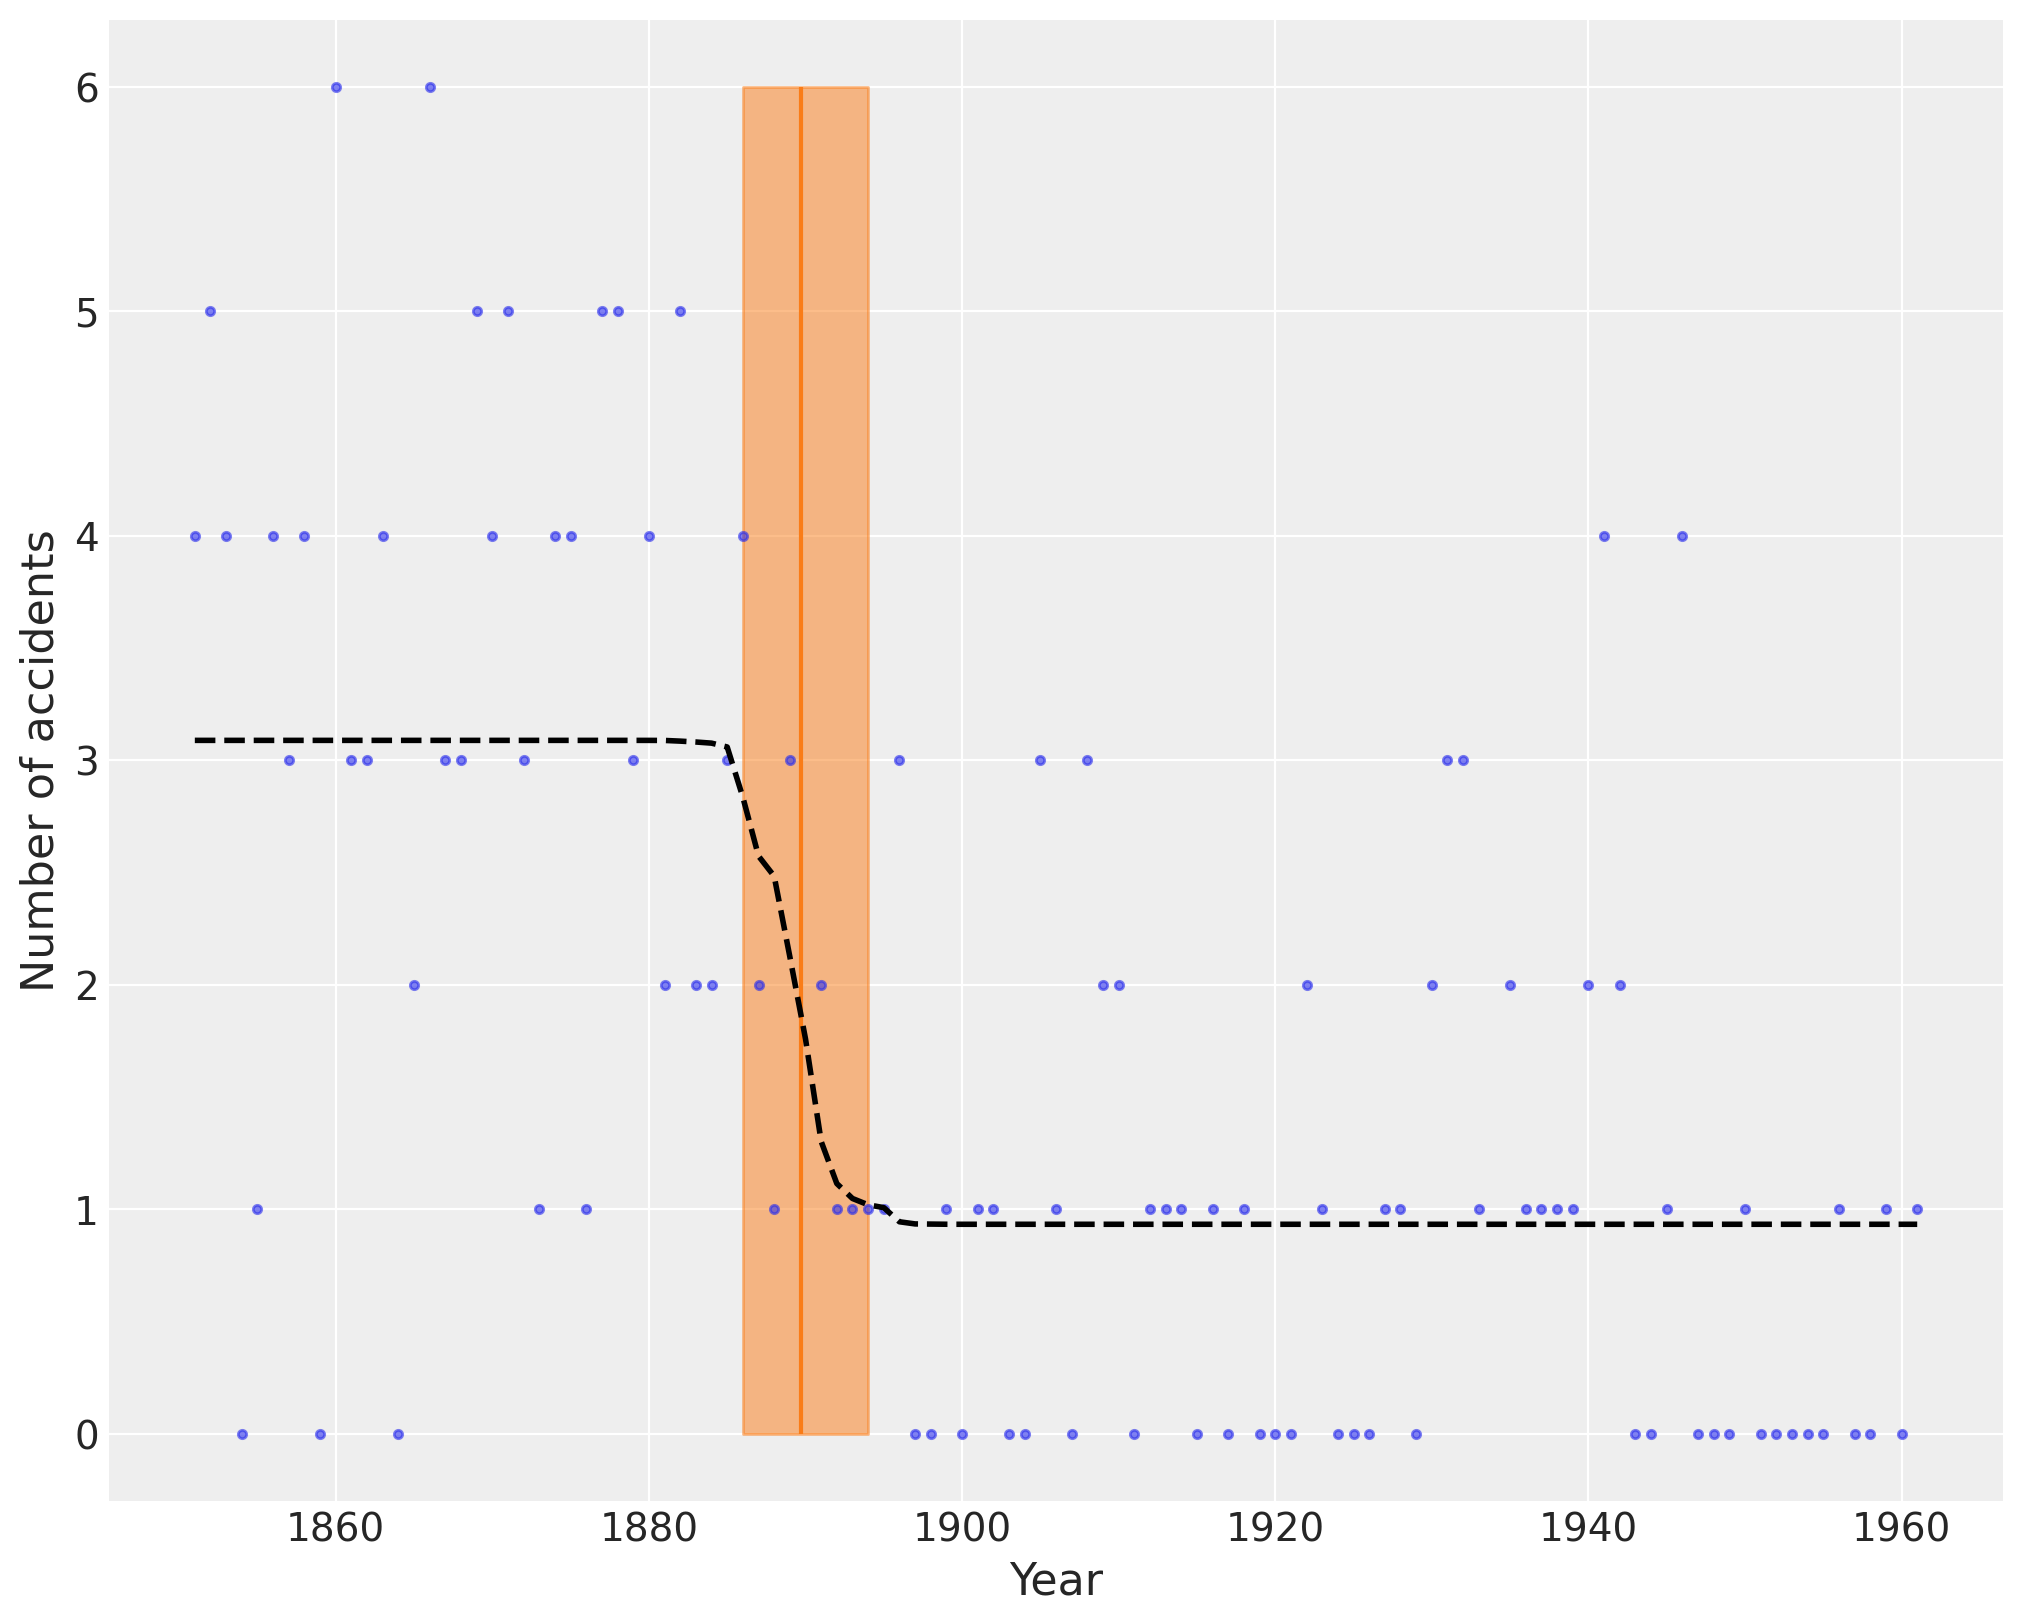

In [64]:
plt.figure(figsize=(10, 8))
plt.plot(years, disaster_data, ".", alpha=0.6)
plt.ylabel("Number of accidents", fontsize=16)
plt.xlabel("Year", fontsize=16)
plt.vlines(trace["switchpoint"].mean(), disaster_data.min(), disaster_data.max(), color="C1")
average_disasters = np.zeros_like(disaster_data, dtype="float")
for i, year in enumerate(years):
    idx = year < trace["switchpoint"]
    average_disasters[i] = np.mean(np.where(idx, trace["early_rate"], trace["late_rate"]))
sp_hpd = az.hdi(idata, var_names=["switchpoint"])["switchpoint"].values
plt.fill_betweenx(
    y=[disaster_data.min(), disaster_data.max()],
    x1=sp_hpd[0],
    x2=sp_hpd[1],
    alpha=0.5,
    color="C1",
)
plt.plot(years, average_disasters, "k--", lw=2);
